<a href="https://colab.research.google.com/github/kaisarfardin6620/LSTM-for-IMDb-Sentiment-Analysis/blob/main/LSTM_for_IMDb_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_path = ('/content/drive/MyDrive/Dataset/imdb')

In [4]:
train = pd.read_csv(base_path + '/train.csv')
test = pd.read_csv(base_path + '/test.csv')

In [5]:
train.shape

(25000, 2)

In [6]:
test.shape

(25000, 2)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       25000 non-null  object
 1   sentiment  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       25000 non-null  object
 1   sentiment  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [9]:
train.describe()

,text,sentiment
count,25000,25000
unique,24904,2
top,"When i got this movie free from my job, along ...",neg
freq,3,12500


In [10]:
test.describe()

,text,sentiment
count,25000,25000
unique,24801,2
top,Loved today's show!!! It was a variety and not...,neg
freq,5,12500


In [11]:
train.head(3)

,text,sentiment
0,"Now, I won't deny that when I purchased this o...",neg
1,"The saddest thing about this ""tribute"" is that...",neg
2,Last night I decided to watch the prequel or s...,neg


In [12]:
test.head(3)

,text,sentiment
0,"My daughter liked it but I was aghast, that a ...",neg
1,I... No words. No words can describe this. I w...,neg
2,this film is basically a poor take on the old ...,neg


In [13]:
train.isnull().sum()

,0
text,0
sentiment,0


In [14]:
test.isnull().sum()

,0
text,0
sentiment,0


In [15]:
train.duplicated().sum()

np.int64(96)

In [16]:
test.duplicated().sum()

np.int64(199)

In [17]:
train = train.drop_duplicates()

In [18]:
test = test.drop_duplicates()

In [19]:
train['sentiment'].value_counts()

,count
sentiment,
pos,12472
neg,12432


In [20]:
test['sentiment'].value_counts()

,count
sentiment,
pos,12440
neg,12361


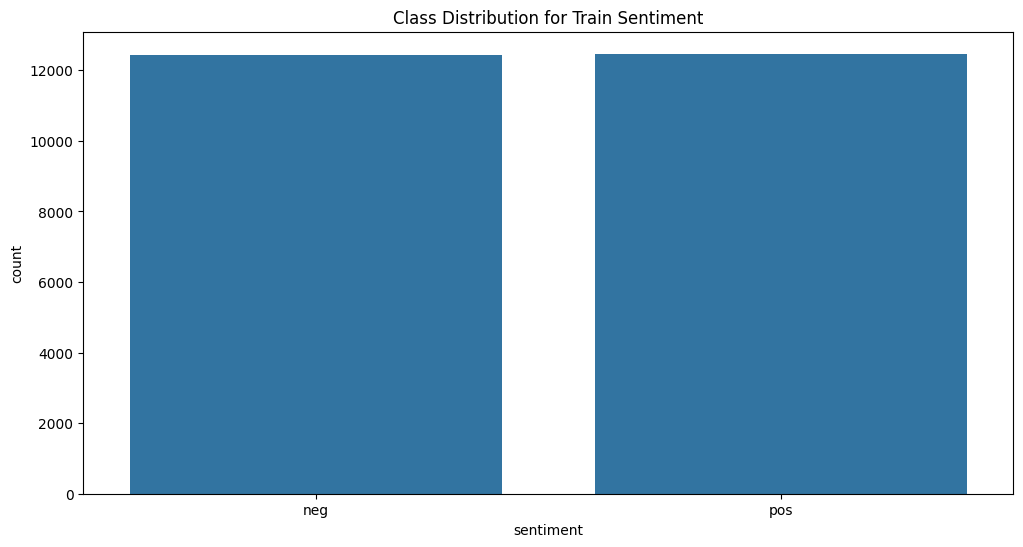

In [21]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment', data=train)
plt.title('Class Distribution for Train Sentiment')
plt.show()

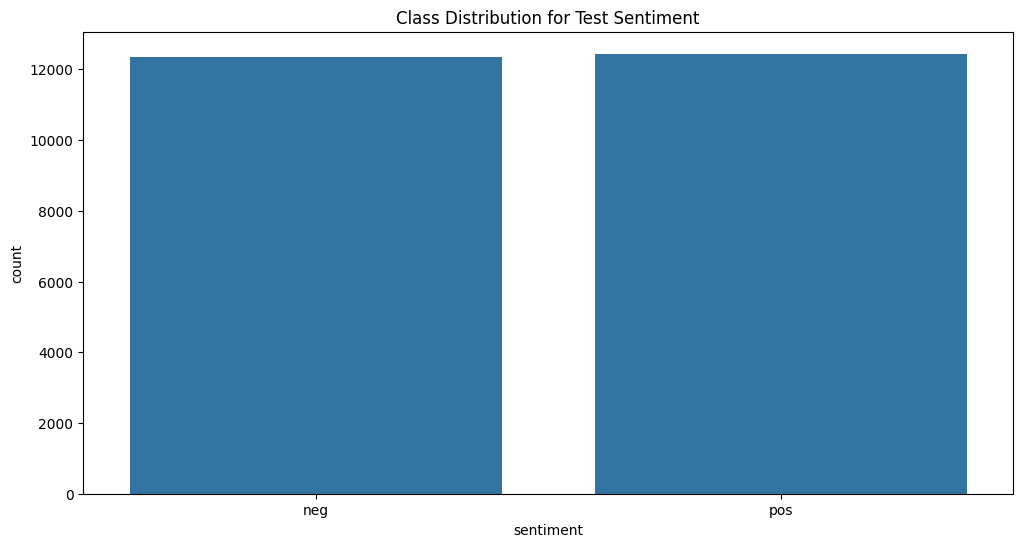

In [22]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment', data=test)
plt.title('Class Distribution for Test Sentiment')
plt.show()

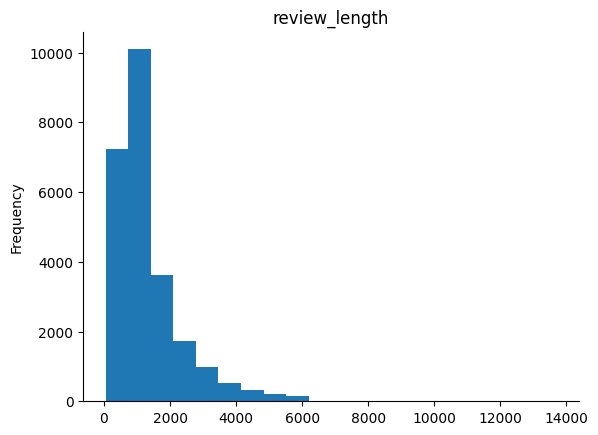

In [23]:
train['review_length'] = train['text'].apply(len) # Create a new column 'review_length' containing the length of each review in the 'text' column
train['review_length'].plot(kind='hist', bins=20, title='review_length')
plt.gca().spines[['top', 'right',]].set_visible(False)

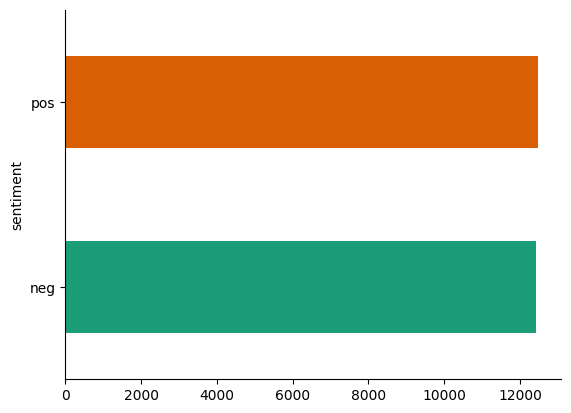

In [24]:
train.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

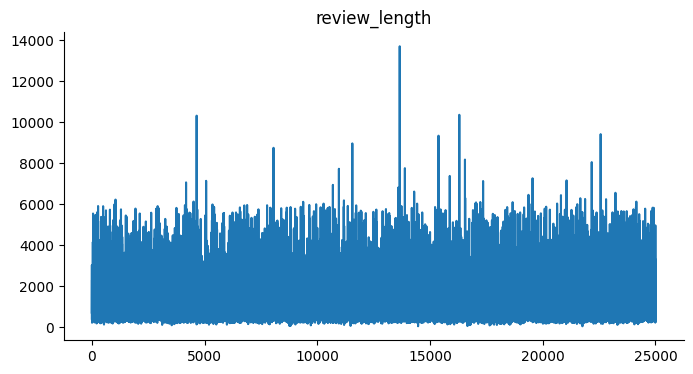

In [25]:
train['review_length'].plot(kind='line', figsize=(8, 4), title='review_length')
plt.gca().spines[['top', 'right']].set_visible(False)

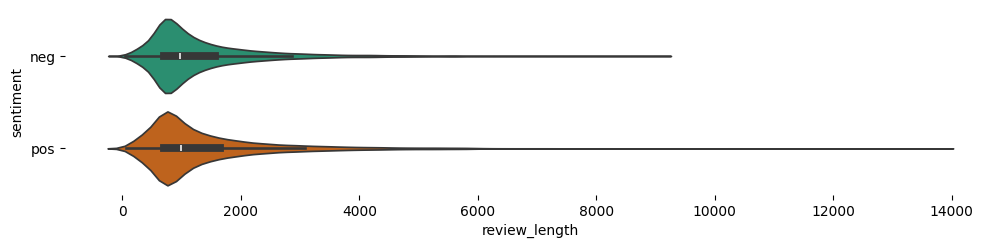

In [26]:
figsize = (12, 1.2 * len(train['sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(train, x='review_length', y='sentiment', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

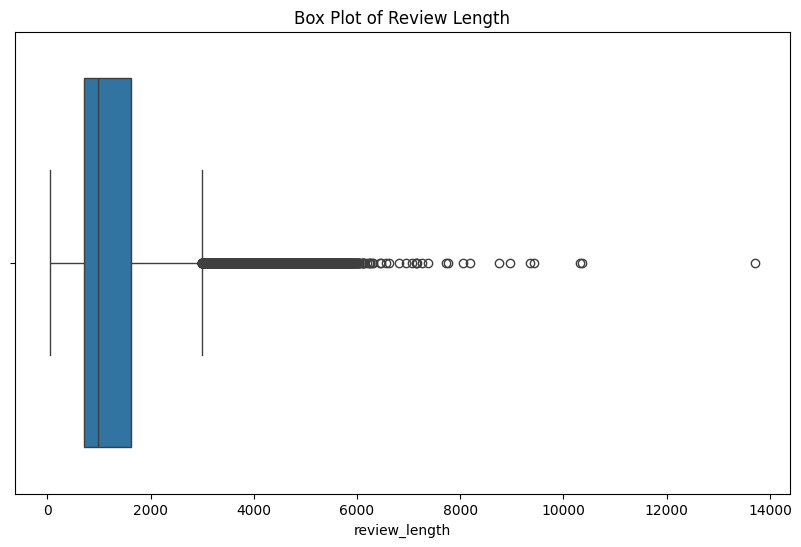

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_length', data=train)
plt.title('Box Plot of Review Length')
plt.show()

In [28]:
def remove_outliers_iqr(data, column):
    if column not in data.columns:
        data[column] = data['text'].apply(len)

    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

    return filtered_data
train = remove_outliers_iqr(train, 'review_length')
test = remove_outliers_iqr(test, 'review_length')

print("Train shape after outlier removal:", train.shape)
print("Test shape after outlier removal:", test.shape)

Train shape after outlier removal: (23073, 3)
Test shape after outlier removal: (22945, 3)


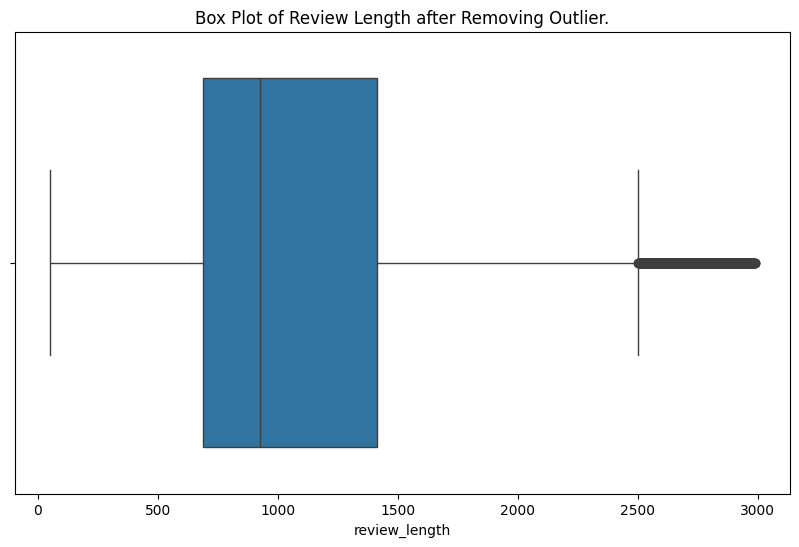

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_length', data=train)
plt.title('Box Plot of Review Length after Removing Outlier.')
plt.show()

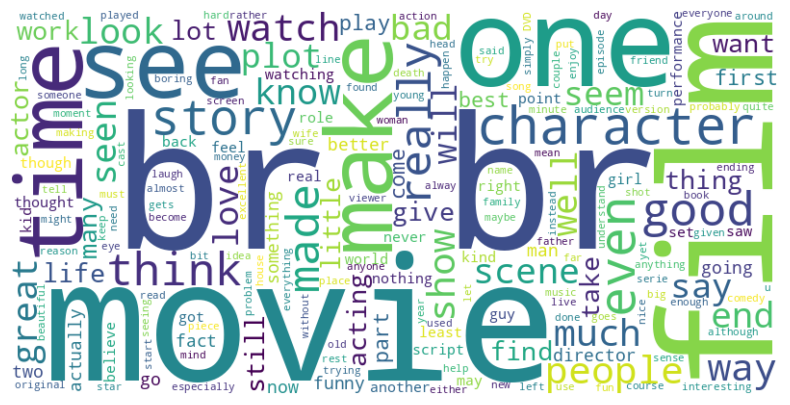

In [30]:
text = ' '.join(train['text'].astype(str).tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

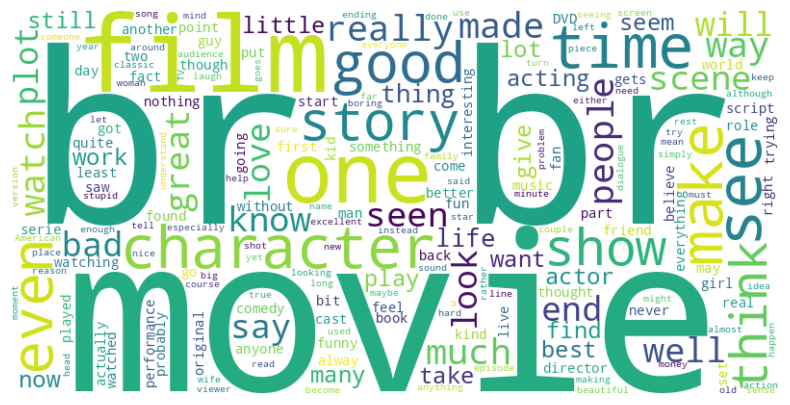

In [31]:
text = ' '.join(test['text'].astype(str).tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [32]:
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [33]:
stopwords = nltk_stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [34]:
def preprocess_text(text):
    text = str(text)
    text = text.lower()

    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    text = re.sub(r'[^\x00-\x7F]+', '', text)

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    text = re.sub(r'\s+', ' ', text).strip()

    words = text.split()

    words = [word for word in words if word not in stopwords and len(word) > 2]
    #words = [word for word in words if word not in stopwords]

    words = [lemmatizer.lemmatize(word) for word in words]

    return " ".join(words)

In [35]:
train['clean_text'] = train['text'].apply(preprocess_text)

In [36]:
test['clean_text'] = test['text'].apply(preprocess_text)

In [37]:
train['sentiment'] = train['sentiment'].replace({'pos': 1, 'neg': 0})
test['sentiment'] = test['sentiment'].replace({'pos': 1, 'neg': 0})

In [38]:
train = train.drop(['text', 'review_length'], axis=1)

In [39]:
test = test.drop(['text', 'review_length'], axis=1)

In [40]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train['clean_text'])
tokenizer.fit_on_texts(test['clean_text'])

In [41]:
train_sequences = tokenizer.texts_to_sequences(train['clean_text'])
test_sequences = tokenizer.texts_to_sequences(test['clean_text'])

In [42]:
max_length = 100
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

In [43]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [44]:
model = Sequential()
model.add(Embedding(10000, 128, input_length=max_length))
model.add(LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.build(input_shape=(None, max_length))

In [45]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,422,849 (5.43 MB)

 Trainable params: 1,422,401 (5.43 MB)

 Non-trainable params: 448 (1.75 KB)

In [46]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
model.fit(train_padded,
          train['sentiment'],
          epochs=30,
          batch_size=64,
          validation_data=(test_padded, test['sentiment']),
          callbacks=[early_stopping])

Epoch 1/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 138s 360ms/step - accuracy: 0.4978 - loss: 1.7332 - val_accuracy: 0.5139 - val_loss: 0.9492
Epoch 2/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 145s 368ms/step - accuracy: 0.5307 - loss: 0.8860 - val_accuracy: 0.6121 - val_loss: 0.7271
Epoch 3/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 163s 427ms/step - accuracy: 0.6233 - loss: 0.7096 - val_accuracy: 0.5065 - val_loss: 0.7217
Epoch 4/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 201s 423ms/step - accuracy: 0.5490 - loss: 0.7085 - val_accuracy: 0.8146 - val_loss: 0.4393
Epoch 5/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 204s 428ms/step - accuracy: 0.8479 - loss: 0.4062 - val_accuracy: 0.8441 - val_loss: 0.3782
Epoch 6/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 200s 423ms/step - accuracy: 0.9078 - loss: 0.2743 - val_accuracy: 0.8373 - val_loss: 0.4252
Epoch 7/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 202s 423ms/step - accuracy: 0.9375 - loss: 0.1998 - val_accuracy: 0.8194 - val_loss: 0.4681
Epoch 8/30
361/361 ━━━━━━━━━━━━━━━━━━━━ 204s 428ms/step - accuracy: 0.9488 -

In [48]:
loss, accuracy = model.evaluate(test_padded, test['sentiment'], verbose=0)
print('Accuracy: {}'.format(accuracy))

Accuracy: 0.8441054821014404
